## 0 Goal

Predict which film is going to be popular 

In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

%matplotlib inline
password = getpass.getpass()
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

········


## 1 Getting the data

In [2]:
# Target variable: popularity score depending on how many times a film was rented
# Defining popularity as follows: If the film is rented more than x times it is consideres as popular, otherwise not popular. I need to find an appropriate threshold

In [3]:
query = '''SELECT f.film_id, f.release_year, c.name AS category, f.rental_rate, f.length, f.rental_duration, f.rating,
r.rental_id, r.rental_date, r.return_date, r.customer_id, r.staff_id, r.inventory_id, 
rc.rental_count
FROM film f
JOIN language l ON f.language_id = l.language_id
JOIN film_category fc ON f.film_id = fc.film_id
JOIN category c ON fc.category_id = c.category_id
JOIN inventory i ON f.film_id = i.film_id
JOIN rental r ON i.inventory_id = r.inventory_id
JOIN (
  SELECT i.film_id, COUNT(*) AS rental_count
  FROM rental r
  JOIN inventory i ON r.inventory_id = i.inventory_id
  GROUP BY i.film_id
) rc ON f.film_id = rc.film_id;'''

data = pd.read_sql_query(query, engine)
data.head()

,film_id,release_year,category,rental_rate,length,rental_duration,rating,rental_id,rental_date,return_date,customer_id,staff_id,inventory_id,rental_count
0,19,2006,Action,0.99,113,6,PG,10895,2005-08-02 01:16:59,2005-08-03 02:41:59,77,2,93,21
1,19,2006,Action,0.99,113,6,PG,12268,2005-08-18 04:26:54,2005-08-23 06:40:54,39,2,93,21
2,19,2006,Action,0.99,113,6,PG,3150,2005-06-20 20:35:28,2005-06-26 01:01:28,34,1,94,21
3,19,2006,Action,0.99,113,6,PG,5072,2005-07-09 05:01:58,2005-07-18 08:17:58,254,2,94,21
4,19,2006,Action,0.99,113,6,PG,9080,2005-07-30 08:02:39,2005-08-06 12:02:39,276,1,94,21


In [4]:
data.describe()

,film_id,release_year,rental_rate,length,rental_duration,rental_id,customer_id,staff_id,inventory_id,rental_count
count,15641.000000,15641.0,15641.000000,15641.000000,15641.000000,15641.000000,15641.000000,15641.000000,15641.000000,15641.000000
mean,500.580462,2006.0,2.944479,114.994246,4.936769,8037.697142,295.889905,1.497730,2289.393645,18.933892
std,288.388638,0.0,1.649141,40.073243,1.400595,4636.399770,172.039640,0.500011,1321.622171,6.270815
min,1.000000,2006.0,0.990000,46.000000,3.000000,1.000000,1.000000,1.000000,1.000000,4.000000
25%,254.000000,2006.0,0.990000,81.000000,4.000000,4023.000000,147.000000,1.000000,1151.000000,14.000000
50%,496.000000,2006.0,2.990000,114.000000,5.000000,8048.000000,294.000000,1.000000,2290.000000,19.000000
75%,751.000000,2006.0,4.990000,148.000000,6.000000,12053.000000,444.000000,2.000000,3427.000000,23.000000
max,1000.000000,2006.0,4.990000,185.000000,7.000000,16050.000000,599.000000,2.000000,4581.000000,33.000000


## 2 Cleaning the Data

### Dealing with Null values 

In [5]:
data.isna().sum()

film_id              0
release_year         0
category             0
rental_rate          0
length               0
rental_duration      0
rating               0
rental_id            0
rental_date          0
return_date        179
customer_id          0
staff_id             0
inventory_id         0
rental_count         0
dtype: int64

In [6]:
# Drop nulls in return_date
data = data[data['return_date'].isna() == False]

In [7]:
data.isna().sum()

film_id            0
release_year       0
category           0
rental_rate        0
length             0
rental_duration    0
rating             0
rental_id          0
rental_date        0
return_date        0
customer_id        0
staff_id           0
inventory_id       0
rental_count       0
dtype: int64

### Cleaning 

In [8]:
data['release_year'].value_counts()

2006    15462
Name: release_year, dtype: int64

In [9]:
# dropping release_year since it contains only one value
data.drop('release_year', axis=1, inplace=True)

In [10]:
# dropping multiple columns since they have no use for prediciting the target
data.drop(labels=['rental_id', 'rental_date', 'return_date', 'customer_id', 'staff_id', 'inventory_id'], axis=1, inplace=True)

In [11]:
data

,film_id,category,rental_rate,length,rental_duration,rating,rental_count
0,19,Action,0.99,113,6,PG,21
1,19,Action,0.99,113,6,PG,21
2,19,Action,0.99,113,6,PG,21
3,19,Action,0.99,113,6,PG,21
4,19,Action,0.99,113,6,PG,21
...,...,...,...,...,...,...,...
15636,989,Travel,4.99,74,4,R,25
15637,989,Travel,4.99,74,4,R,25
15638,989,Travel,4.99,74,4,R,25
15639,989,Travel,4.99,74,4,R,25


### Target creation 

In [12]:
data.describe()

,film_id,rental_rate,length,rental_duration,rental_count
count,15462.000000,15462.000000,15462.000000,15462.000000,15462.000000
mean,500.742983,2.946021,115.023154,4.938430,18.938753
std,288.256793,1.649167,40.089346,1.400643,6.273569
min,1.000000,0.990000,46.000000,3.000000,4.000000
25%,255.000000,0.990000,81.000000,4.000000,14.000000
50%,496.000000,2.990000,114.000000,5.000000,19.000000
75%,751.000000,4.990000,148.000000,6.000000,23.000000
max,1000.000000,4.990000,185.000000,7.000000,33.000000


In [13]:
# Compute the mean and median of rental_count
rental_count_mean = data['rental_count'].mean()
rental_count_median = data['rental_count'].median()
print(f"Mean = {rental_count_mean}")
print(f"Median = {rental_count_median}")

Mean = 18.9387530720476
Median = 19.0


In [14]:
# Add a new column called 'popularity'. Threshold is set based on the calculation above.
data['popularity'] = data['rental_count'].apply(lambda x: 'popular' if x > 18 else 'not popular')

In [15]:
data

,film_id,category,rental_rate,length,rental_duration,rating,rental_count,popularity
0,19,Action,0.99,113,6,PG,21,popular
1,19,Action,0.99,113,6,PG,21,popular
2,19,Action,0.99,113,6,PG,21,popular
3,19,Action,0.99,113,6,PG,21,popular
4,19,Action,0.99,113,6,PG,21,popular
...,...,...,...,...,...,...,...,...
15636,989,Travel,4.99,74,4,R,25,popular
15637,989,Travel,4.99,74,4,R,25,popular
15638,989,Travel,4.99,74,4,R,25,popular
15639,989,Travel,4.99,74,4,R,25,popular


## 3 Exploring the data

In [16]:
data.shape

(15462, 8)

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15462 entries, 0 to 15640
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   film_id          15462 non-null  int64  
 1   category         15462 non-null  object 
 2   rental_rate      15462 non-null  float64
 3   length           15462 non-null  int64  
 4   rental_duration  15462 non-null  int64  
 5   rating           15462 non-null  object 
 6   rental_count     15462 non-null  int64  
 7   popularity       15462 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 1.1+ MB


In [18]:
data['category'].value_counts()

Sports         1132
Animation      1115
Action         1075
Sci-Fi         1069
Family         1052
Drama          1027
Documentary    1014
Foreign         992
Games           941
Children        908
Classics        907
Comedy          905
New             898
Horror          814
Travel          813
Music           800
Name: category, dtype: int64

In [19]:
data['rating'].value_counts()

PG-13    3447
NC-17    3175
PG       3086
R        3081
G        2673
Name: rating, dtype: int64

In [20]:
data.describe()

,film_id,rental_rate,length,rental_duration,rental_count
count,15462.000000,15462.000000,15462.000000,15462.000000,15462.000000
mean,500.742983,2.946021,115.023154,4.938430,18.938753
std,288.256793,1.649167,40.089346,1.400643,6.273569
min,1.000000,0.990000,46.000000,3.000000,4.000000
25%,255.000000,0.990000,81.000000,4.000000,14.000000
50%,496.000000,2.990000,114.000000,5.000000,19.000000
75%,751.000000,4.990000,148.000000,6.000000,23.000000
max,1000.000000,4.990000,185.000000,7.000000,33.000000


### Dealing with multicollinearity 

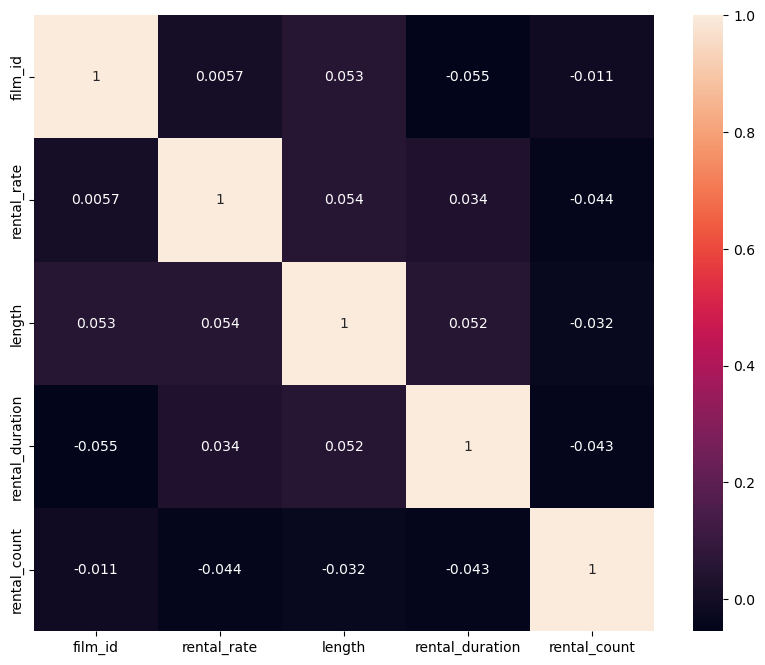

In [21]:
corr_matrix=data.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

### Checking distribution

C:\Users\fekad\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


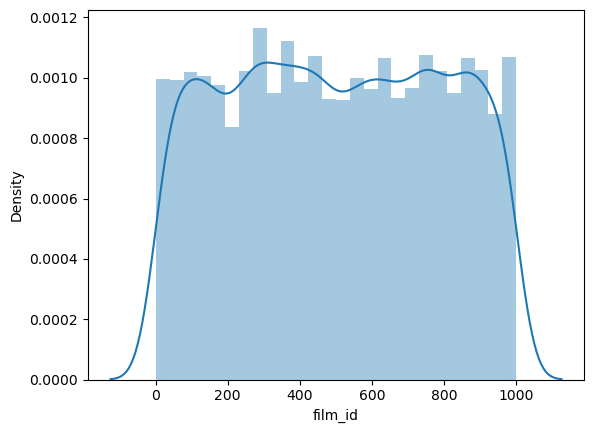

C:\Users\fekad\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


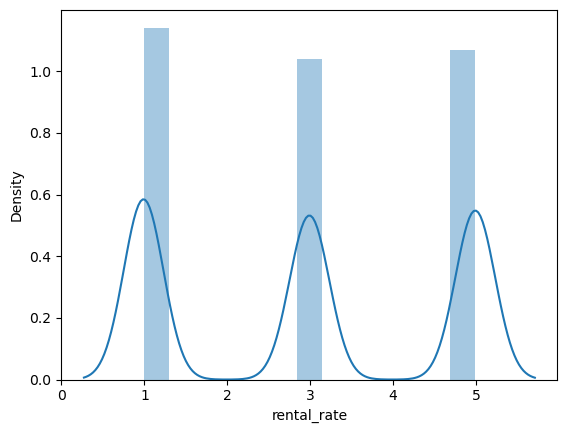

C:\Users\fekad\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


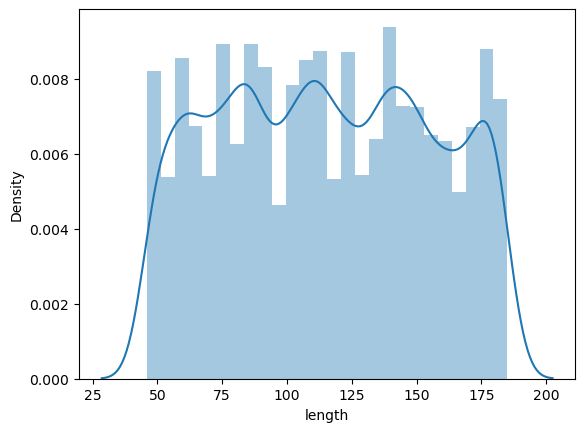

C:\Users\fekad\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


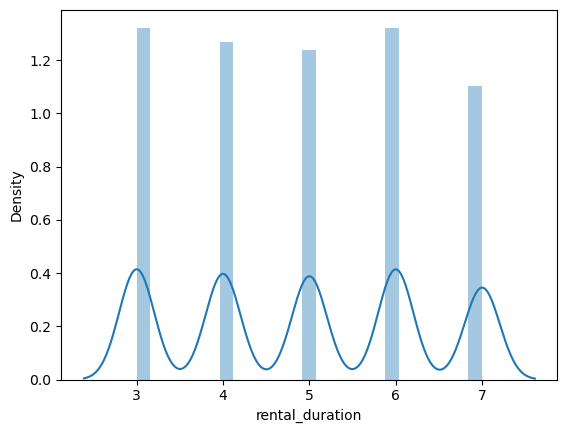

C:\Users\fekad\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


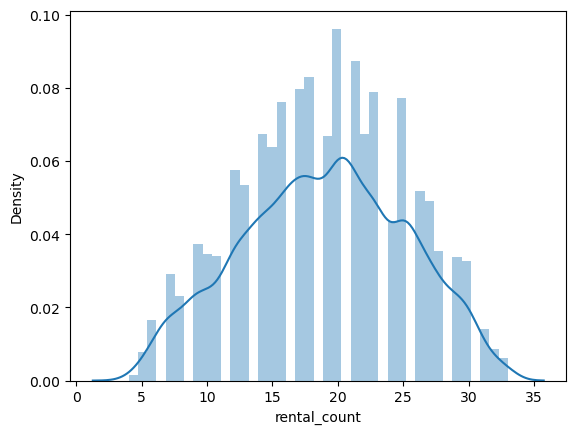

In [22]:
num = data.select_dtypes(include = np.number)

for i in num:
    sns.distplot(num[i])
    plt.show()

## 4 Processing Data

### Normalizing the data

In [23]:
X = data.select_dtypes(include = np.number)

transformer = StandardScaler().fit(X)
x_normalized = transformer.transform(X)
x = pd.DataFrame(x_normalized)
x.columns = X.columns
x.head()

,film_id,rental_rate,length,rental_duration,rental_count
0,-1.671283,-1.186104,-0.050468,0.757941,0.328571
1,-1.671283,-1.186104,-0.050468,0.757941,0.328571
2,-1.671283,-1.186104,-0.050468,0.757941,0.328571
3,-1.671283,-1.186104,-0.050468,0.757941,0.328571
4,-1.671283,-1.186104,-0.050468,0.757941,0.328571


C:\Users\fekad\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


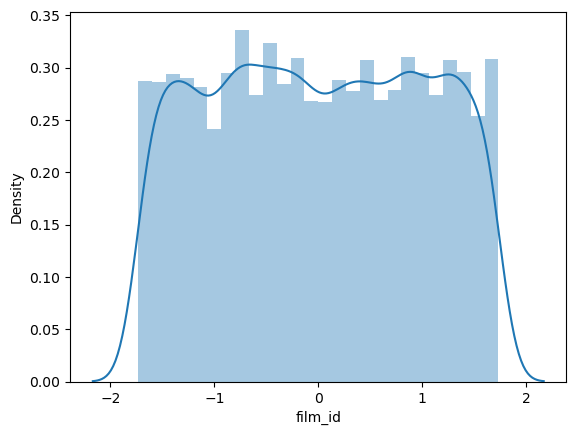

C:\Users\fekad\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


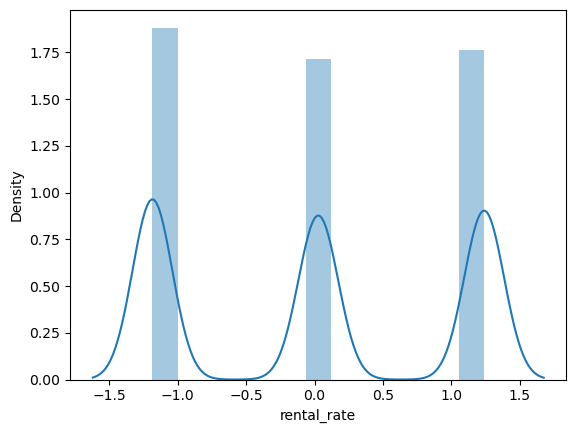

C:\Users\fekad\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


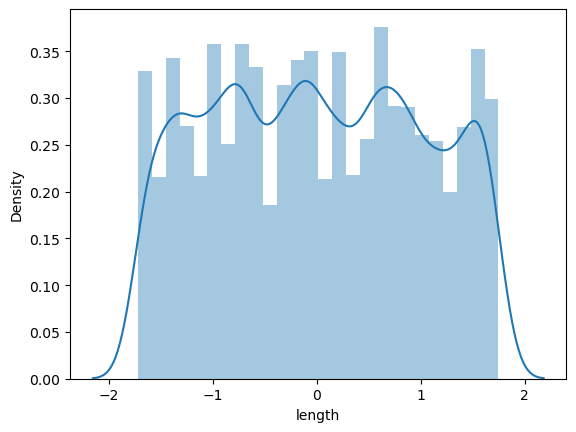

C:\Users\fekad\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


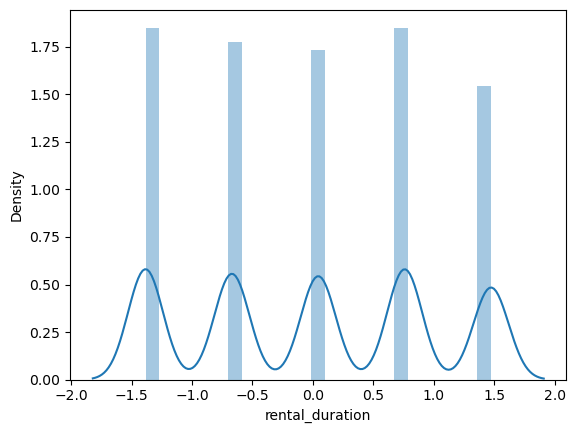

C:\Users\fekad\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


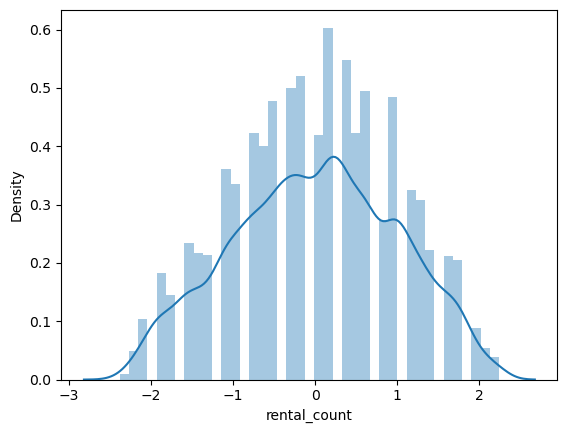

In [24]:
for i in x:
    sns.distplot(x[i])
    plt.show()

In [25]:
cat = data.select_dtypes(include = np.object)
cat.head()

C:\Users\fekad\AppData\Local\Temp\ipykernel_5004\1108559247.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cat = data.select_dtypes(include = np.object)


,category,rating,popularity
0,Action,PG,popular
1,Action,PG,popular
2,Action,PG,popular
3,Action,PG,popular
4,Action,PG,popular


In [26]:
cat = cat.drop(['popularity'], axis=1)
categorical = pd.get_dummies(cat, columns=['category', 'rating'])
categorical.head()

,category_Action,category_Animation,category_Children,category_Classics,category_Comedy,category_Documentary,category_Drama,category_Family,category_Foreign,category_Games,...,category_Music,category_New,category_Sci-Fi,category_Sports,category_Travel,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## 5 Modeling

### Train-Test Split and Training Model

#### Once the data is ready we need to keep the target appart from the rest
#### With all the columns (numerical and encoded categoricals) and without the target we need to split it into
#### training (70%) and testing (30%) datasets. Then we will train the model using the training part.
#### We will predict using the testing part, so we can know how well our model perform.

In [27]:
data.popularity.unique()

array(['popular', 'not popular'], dtype=object)

In [28]:
y = data['popularity'] # Target appart
X = np.concatenate((x, categorical), axis=1) # Numerical and dummies from categoricals

In [29]:
# Separate training and testing datasets and correspondant targets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [30]:
len(X_train)

10823

In [31]:
y_train

4125         popular
15448    not popular
7880         popular
11292    not popular
2792         popular
            ...     
12260    not popular
8125         popular
14308    not popular
7010         popular
5703     not popular
Name: popularity, Length: 10823, dtype: object

In [32]:
# We train the training dataset using Logistic Regression 
logistic = LogisticRegression(random_state=0).fit(X_train, y_train)

In [33]:
# We predict on the testing dataset
predictions = logistic.predict(X_test)

### Check how well the model performs

In [34]:
pd.Series(predictions).value_counts()

popular        2465
not popular    2174
dtype: int64

In [35]:
y_test.value_counts()

popular        2465
not popular    2174
Name: popularity, dtype: int64

In [36]:
# Accuracy
logistic.score(X_test, y_test)

1.0

In [37]:
# Accuracy
from sklearn.metrics import accuracy_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, predictions)))


Accuracy: 1.00



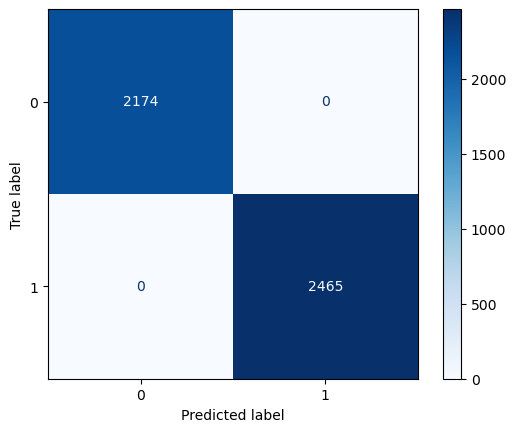

In [38]:
# Compute the confusion matrix (saw it ins Isi´s repo, thanks!)
cm = confusion_matrix(y_test, predictions)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

### FOR THE ROC CURVE WE NEED TO BINARIZE THE TARGET (ONEvsALL)

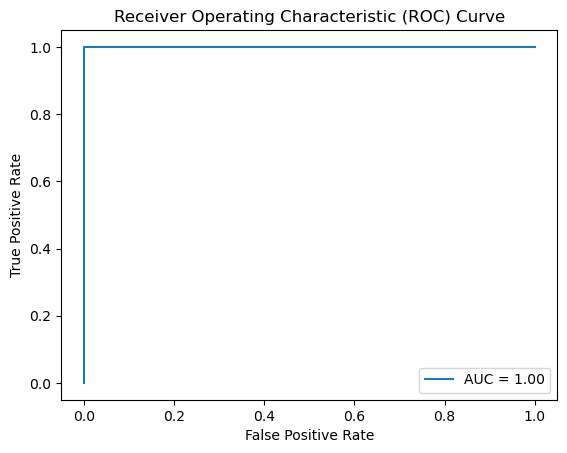

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Get predicted probabilities for positive class
y_pred_proba = logistic.predict_proba(X_test)[:, 1]

# Calculate fpr, tpr, and threshold values for ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label='popular')

# Calculate AUC score
auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()
